# Выбор локации для скважины

**Описание проекта**

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Данные геологоразведки трёх регионов находятся в файлах: 

* /datasets/geo_data_0.csv,

* /datasets/geo_data_1.csv,

* /datasets/geo_data_2.csv,

где: 
   * id — уникальный идентификатор скважины;
   * f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
   * product — объём запасов в скважине (тыс. баррелей).

**Условия задачи:**

* Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
* Бюджет на разработку скважин в регионе — 10 млрд рублей.
* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
* Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

**Библиотеки и константы**

In [1]:
!pip install --upgrade scikit-learn -q
!pip install phik -q
!pip install shap -q
!pip install imblearn -q

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import phik
import sklearn

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score, mean_squared_error

import warnings

warnings.filterwarnings("ignore")
mpl.style.use(['bmh'])


In [2]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

## Загрузка и подготовка данных

In [3]:
try:
    df_0 = pd.read_csv('geo_data_0.csv')
except:
    df_0 = pd.read_csv('/datasets/geo_data_0.csv')
try:
    df_1 = pd.read_csv('geo_data_1.csv')
except:
    df_1 = pd.read_csv('/datasets/geo_data_1.csv')
try:
    df_2 = pd.read_csv('geo_data_2.csv')
except:
    df_2 = pd.read_csv('/datasets/geo_data_2.csv')

**df_0**

In [4]:
df_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


В датафрейме df_0 данные соответствуют описанию. 

In [5]:
df_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Датафрейм df_0 состоит из 100 000 наблюдений и 4 переменных. Пропусков в данных нет. Типы данных соответствуют описанию.

In [6]:
df_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


Поскольку значения признаков f0, f1, f2 нам неизвестны, сложно оценить их числовые диапазоны.  Признак product (объем запасов в скважине, тыс. баррелей) принимает значения от 0 до 185. Положительным моментом является отсутствие отрицательных значений.

**df_1**

In [7]:
df_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


В датафрейме df_1 данные соответствуют описанию. 

In [8]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Датафрейм df_1 состоит из 100 000 наблюдений и 4 переменных. Пропусков в данных нет. Типы данных соответствуют описанию.

In [9]:
df_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


**df_2**

In [10]:
df_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


В датафрейме df_2 данные соответствуют описанию.

In [11]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Датафрейм df_2 состоит из 100 000 наблюдений и 4 переменных. Пропусков в данных нет. Типы данных соответствуют описанию.

In [12]:
df_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Числовые диапазоны, которые принимают признаки f0, f1, f2, различаются для разных регионов.

Проверим отсутствие дубликатов.

In [13]:
df_list = [df_0, df_1, df_2]

for df in df_list:
    print(f'Количество дубликатов: {df.duplicated().sum()}')

Количество дубликатов: 0
Количество дубликатов: 0
Количество дубликатов: 0


<div style="background-color: PaleTurquoise; padding: 20px"> <b>Вывод:</b> в данном разделе были загружены данные для трёх регионов в датасеты df_0, df_1 и df_2. Пропуски в данных отсутствуют, данные соответствуют описанию, дубликаты не обнаружены, типы данных соответствуют описанию. Далее мы рассмотрим распределения данных и проведём корреляционный анализ.
</div>

##  Исследовательский и корреляционный анализ

Напишем функцию **creating_graph** для автоматического построения графика распределения.

In [14]:
def creating_graph(df, column, bins=(df.shape[0] // 300)):
    """
    Визуализирует распределение данных в заданном столбце датафрейма.

  Args:
    df: pandas.DataFrame, датафрейм, содержащий данные.
    column: str, название столбца, для которого нужно построить визуализацию.
    bins: int, количество корзин для гистограммы.

  Returns:
    Функция отображает график в зависимости от типа столбца (категориальный, дискретный, непрерывный).
    """
    if df[column].dtypes == 'int64' or df[column].dtypes == 'float64':
        
        if df[column].nunique() <= 4:#дискретный
            print(df[column].describe())
            
            pivot_table = df.pivot_table(index=column, 
                                   values='id', 
                                   aggfunc='count')

            ax = pivot_table.plot(kind='bar', figsize=(12, 8))

            for p in ax.patches:
                ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                            ha='center', va='center', xytext=(0, 10), textcoords='offset points')

            plt.ylabel('Количество наблюдений')
            plt.title('Распределение признака ' + column)
            
        else:#непрерывный
            print(df[column].describe())
        
            fig = plt.figure(figsize=(12, 8))
            grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)
        
            ax_main = fig.add_subplot(grid[:-1, :-1])
            ax_bottom = fig.add_subplot(grid[-1, 0:-1], xticklabels=[], yticklabels=[])
        
            ax_main.hist(df[column], bins=bins, edgecolor='black')
            sns.boxplot(x=df[column], ax=ax_bottom)
            ax_main.set(title='Распределение признака ' + column, ylabel='Количество наблюдений')
        
    else:#категориальный
        print(df[column].value_counts())
        
        fig = plt.figure(figsize=(12, 8))
        df[column].value_counts().plot(kind = 'pie', autopct='%1.0f%%',
                                       wedgeprops=dict(width=0.3),
                                       title = 'Распределение признака ' + column, ylabel='')
       
    plt.show()

Распределения будем рассматривать не для каждого датафрейма в отдельности, а в разрезе признаков, чтобы сравнить распределение признака для каждого датафрейма.

**f0**

count    100000.000000
mean          0.500419
std           0.871832
min          -1.408605
25%          -0.072580
50%           0.502360
75%           1.073581
max           2.362331
Name: f0, dtype: float64


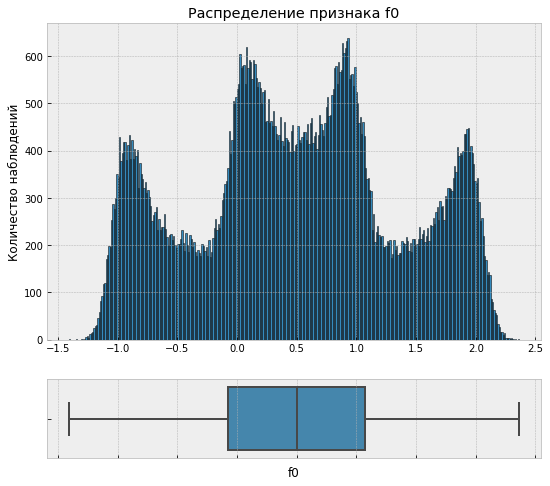

In [15]:
creating_graph(df_0, 'f0')

Распределение признака f0 в датафрейме df_0 имеет полимодальный характер с четырьмя ярко выраженными вершинами. При этом распределение демонстрирует высокую степень симметричности.  Стоит отметить, что медиана и среднее значение признака совпадают и равны 0.5.

count    100000.000000
mean          1.141296
std           8.965932
min         -31.609576
25%          -6.298551
50%           1.153055
75%           8.621015
max          29.421755
Name: f0, dtype: float64


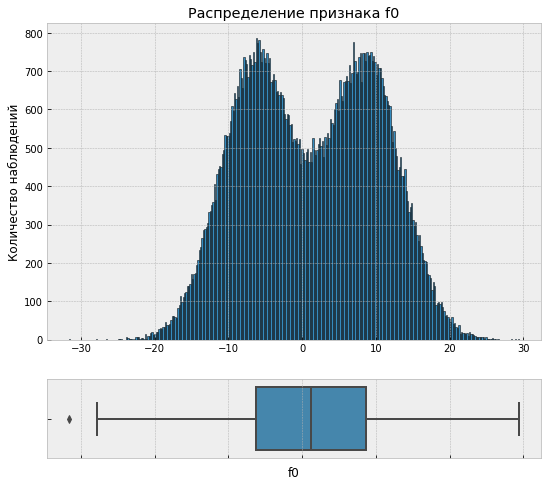

In [16]:
creating_graph(df_1, 'f0')

Распределение признака f0 в датафрейме df_1 также имеет полимодальный характер, но с двумя вершинами.  Распределение сохраняет симметричность, однако диапазон принимаемых значений значительно шире по сравнению с df_0.

Также стоит отметить наличие значений, выходящих за пределы межквартильного размаха. Вероятно, такие значения будут встречаться и в дальнейшем.  Мы не будем предпринимать никаких действий в отношении этих значений.

count    100000.000000
mean          0.002023
std           1.732045
min          -8.760004
25%          -1.162288
50%           0.009424
75%           1.158535
max           7.238262
Name: f0, dtype: float64


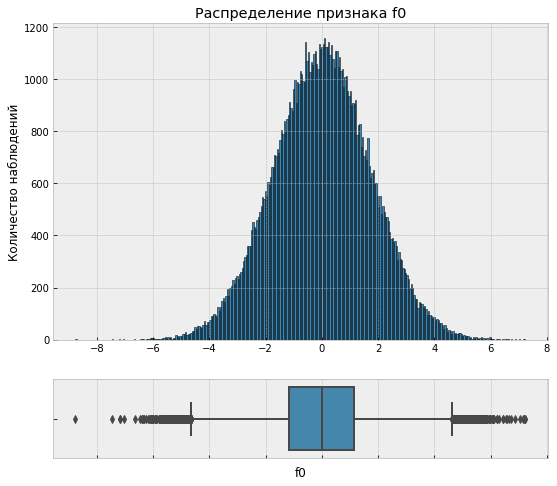

In [17]:
creating_graph(df_2, 'f0')

Распределение признака f0 в датафрейме df_2 близко к нормальному.

**f1**

count    100000.000000
mean          0.250143
std           0.504433
min          -0.848218
25%          -0.200881
50%           0.250252
75%           0.700646
max           1.343769
Name: f1, dtype: float64


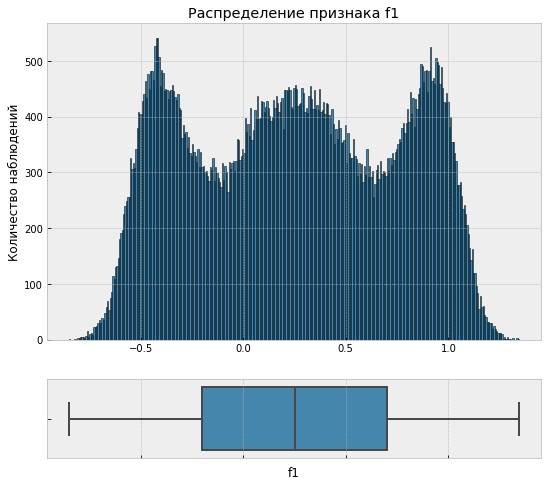

In [18]:
creating_graph(df_0, 'f1')

Распределение признака f1 в датафрейме df_0 имеет полимодальный характер с тремя вершинами. При этом распределение демонстрирует высокую степень симметричности.

count    100000.000000
mean         -4.796579
std           5.119872
min         -26.358598
25%          -8.267985
50%          -4.813172
75%          -1.332816
max          18.734063
Name: f1, dtype: float64


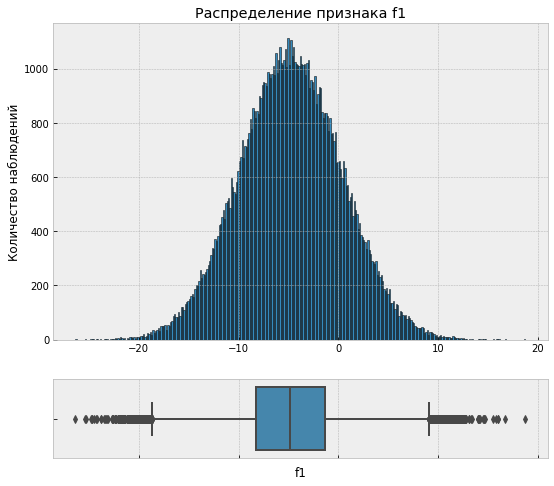

In [19]:
creating_graph(df_1, 'f1')

Распределение признака f1 в датафрейме df_1 близко к нормальному.При этом распределение симметрично. Медианное и среднее значение признака находятся в районе -4.8.

count    100000.000000
mean         -0.002081
std           1.730417
min          -7.084020
25%          -1.174820
50%          -0.009482
75%           1.163678
max           7.844801
Name: f1, dtype: float64


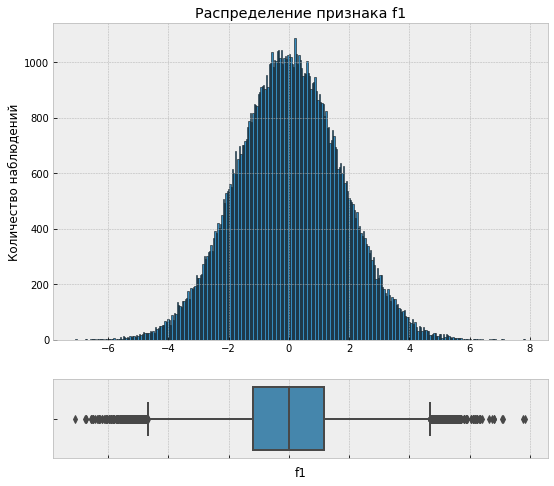

In [20]:
creating_graph(df_2, 'f1')

Распределение признака f1 в датафрейме df_2 близко к нормальному. Медианное и среднее значение признака близки к 0, что указывает на симметричность данных.

**f2**

count    100000.000000
mean          2.502647
std           3.248248
min         -12.088328
25%           0.287748
50%           2.515969
75%           4.715088
max          16.003790
Name: f2, dtype: float64


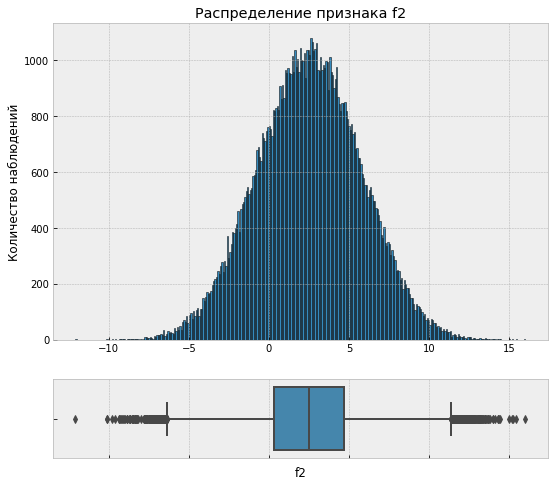

In [21]:
creating_graph(df_0, 'f2')

Распределение признака f2 в датафрейме df_0 близко к нормальному. Медианное и среднее значение признака находятся в районе 2.5, что свидетельствует о симметричности данных.

count    100000.000000
mean          2.494541
std           1.703572
min          -0.018144
25%           1.000021
50%           2.011479
75%           3.999904
max           5.019721
Name: f2, dtype: float64


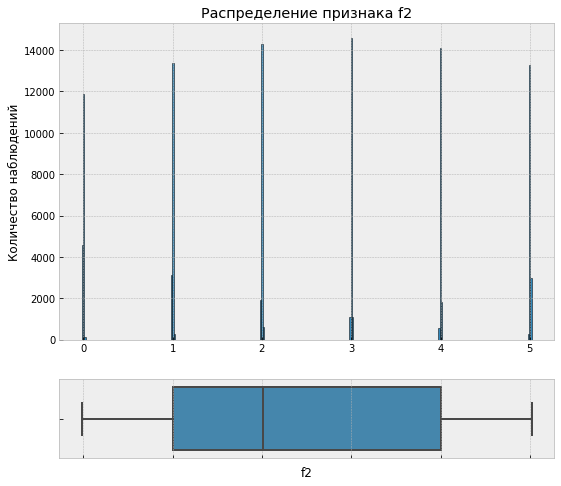

In [22]:
creating_graph(df_1, 'f2')

Распределение признака f2 в датафрейме df_1 имеет необычный характер и существенно отличается от распределений в других регионах.  Предположительно, такая форма распределения обусловлена тем, что данные сгруппированы вокруг дискретных значений от 0 до 5 (6 значений) с определенным среднеквадратическим отклонением. 

count    100000.000000
mean          2.495128
std           3.473445
min         -11.970335
25%           0.130359
50%           2.484236
75%           4.858794
max          16.739402
Name: f2, dtype: float64


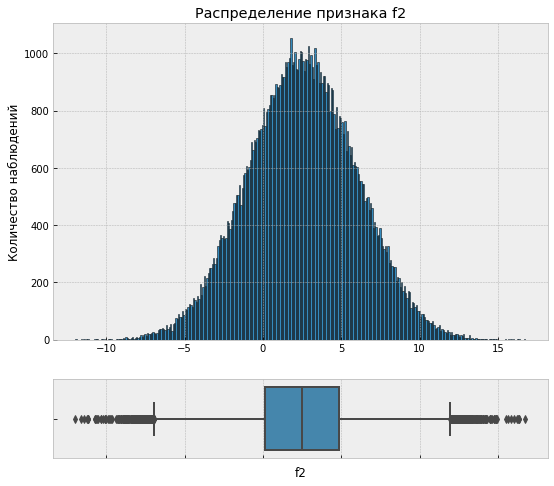

In [23]:
creating_graph(df_2, 'f2')

Распределение признака f2 в датафрейме df_2 близко к нормальному. Медианное и среднее значение признака находятся в районе 2.5, что свидетельствует о симметричности данных.

**product**

count    100000.000000
mean         92.500000
std          44.288691
min           0.000000
25%          56.497507
50%          91.849972
75%         128.564089
max         185.364347
Name: product, dtype: float64


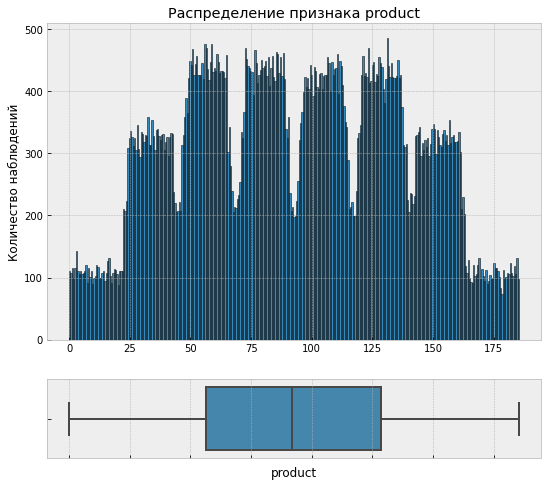

In [24]:
creating_graph(df_0, 'product')

Распределение целевого признака product в датафрейме df_0 имеет полимодальный характер с восемью вершинами.

count    100000.000000
mean         68.825000
std          45.944423
min           0.000000
25%          26.953261
50%          57.085625
75%         107.813044
max         137.945408
Name: product, dtype: float64


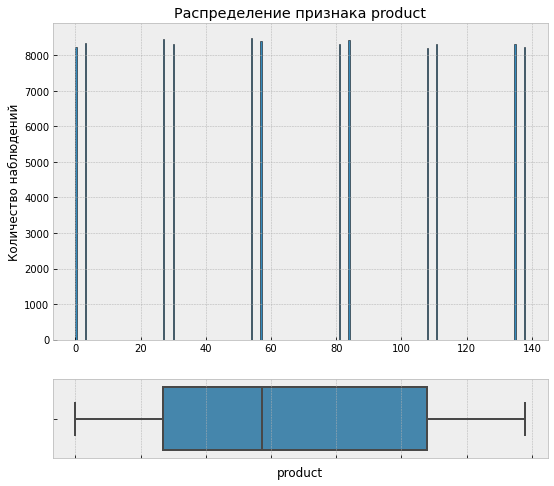

In [25]:
creating_graph(df_1, 'product')

Также наблюдается нестандартное распределение, отличающееся от остальных.

count    100000.000000
mean         95.000000
std          44.749921
min           0.000000
25%          59.450441
50%          94.925613
75%         130.595027
max         190.029838
Name: product, dtype: float64


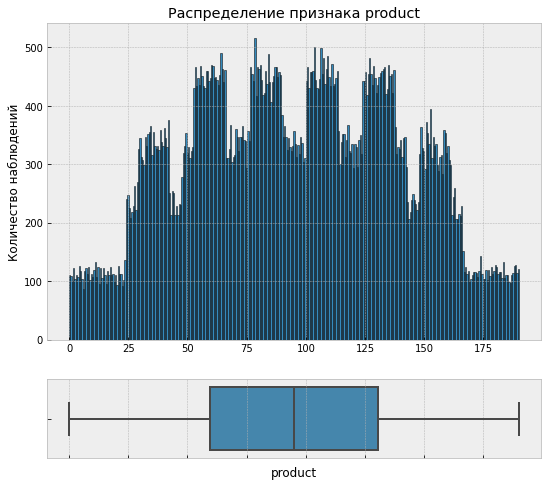

In [26]:
creating_graph(df_2, 'product')

Распределение целевого признака product в датафрейме df_2 также имеет полимодальный характер с восемью вершинами.

Рассмотрим корреляцию между фичами и целевым признаком

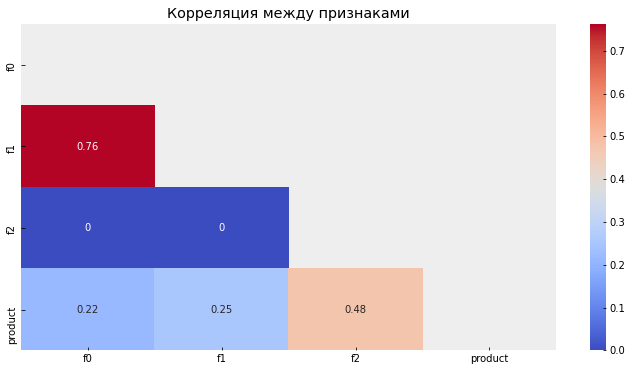

In [27]:
nam_col_names = df_0.drop('id', axis=1).select_dtypes(include='number').columns.tolist()

phik_matrix = df_0.drop('id', axis=1).phik_matrix(interval_cols=nam_col_names)

mask = np.triu(np.ones_like(phik_matrix, dtype=bool))

plt.figure(figsize=(12, 6))
sns.heatmap(phik_matrix, annot=True, cmap='coolwarm', mask=mask)
plt.title('Корреляция между признаками')
plt.show()

В датафрейме df_0 наиболее сильная корреляция с целевым признаком product наблюдается у признака f2 (0.48). Далее следуют признаки f1 (0.25) и f0 (0.22).  Также стоит отметить высокую корреляцию между признаками f1 и f0 (0.76).

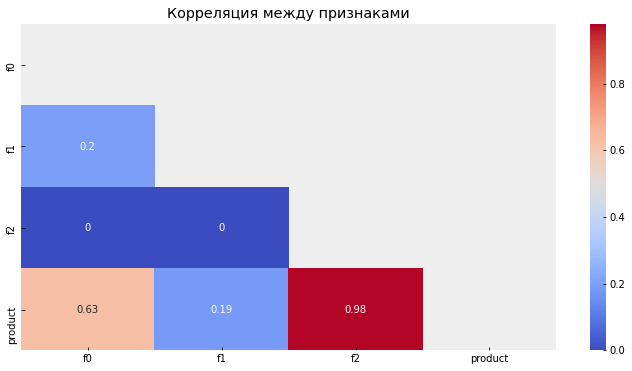

In [28]:
nam_col_names = df_1.drop('id', axis=1).select_dtypes(include='number').columns.tolist()

phik_matrix = df_1.drop('id', axis=1).phik_matrix(interval_cols=nam_col_names)

mask = np.triu(np.ones_like(phik_matrix, dtype=bool))

plt.figure(figsize=(12, 6))
sns.heatmap(phik_matrix, annot=True, cmap='coolwarm', mask=mask)
plt.title('Корреляция между признаками')
plt.show()

В датафрейме df_1 обнаружена сильная линейная взаимосвязь между целевым признаком (таргетом) и признаком f2, что объясняется их распределением (коэффициент корреляции 0.98).  Также целевой признак демонстрирует хорошую корреляцию с признаком f0 (0.63).

 Целесообразно удалить признак f2 из датафрейма df_1.

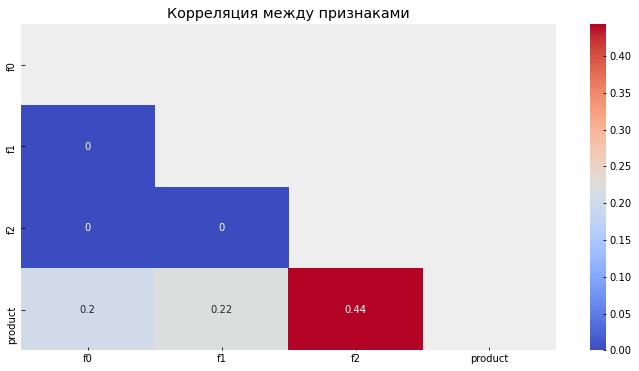

In [29]:
nam_col_names = df_2.drop('id', axis=1).select_dtypes(include='number').columns.tolist()

phik_matrix = df_2.drop('id', axis=1).phik_matrix(interval_cols=nam_col_names)

mask = np.triu(np.ones_like(phik_matrix, dtype=bool))

plt.figure(figsize=(12, 6))
sns.heatmap(phik_matrix, annot=True, cmap='coolwarm', mask=mask)
plt.title('Корреляция между признаками')
plt.show()

В датафрейме df_2 признаки практически не коррелируют между собой.  Наибольшая корреляция с целевым признаком (таргетом) наблюдается у признака f2 и составляет 0.44. Далее следуют признаки f1 (0.22) и f0 (0.2).

<div style="background-color: PaleTurquoise; padding: 20px"> <b>Вывод:</b> 

df_0:

* f0: Полимодальное распределение с 4 вершинами, симметричное, медиана и среднее равны 0.5.
* f1: Полимодальное распределение с 3 вершинами, симметричное.
* f2: Близко к нормальному распределению, симметричное, медиана и среднее около 2.5.
* product (целевой признак): Полимодальное распределение с 8 вершинами, нестандартное.
* Наиболее сильная корреляция с целевым признаком product: f2 (0.48). Далее следуют: f1 (0.25) и f0 (0.22)
* Высокая корреляция между признаками: f1 и f0 (0.76)

df_1:

* f0: Полимодальное распределение с 2 вершинами, симметричное, широкий диапазон значений.
* f1: Близко к нормальному распределению, симметричное, медиана и среднее около -4.8.
* f2: Необычное распределение, данные сгруппированы вокруг дискретных значений от 0 до 5.
* product (целевой признак):  Наблюдается нестандартное распределение, отличающееся от остальных.
* Сильная линейная взаимосвязь с целевым признаком: f2 (0.98).
* Хорошая корреляция с целевым признаком: f0 (0.63)

df_2:

* f0: Близко к нормальному распределению.
* f1: Близко к нормальному распределению, симметричное, медиана и среднее около 0.
* f2: Близко к нормальному распределению, симметричное, медиана и среднее около 2.5.
* product (целевой признак): Полимодальное распределение с 8 вершинами.
* Признаки практически не коррелируют между собой.
* Наибольшая корреляция с целевым признаком: f2 (0.44). Далее следуют: f1 (0.22) и f0 (0.2)
</div>

## Обучение и проверка модели

Произведем замену индексов в датафреймах df_0, df_1 и df_2 на идентификаторы (id).

In [30]:
df_0 = df_0.set_index('id')
df_1 = df_1.set_index('id')
df_2 = df_2.set_index('id')

In [31]:
df_list = [df_0, df_1, df_2]
df_name_list = ['df_0', 'df_1', 'df_2']

Создадим словарь model_dict для хранения информации о моделях линейной регрессии, включая:
   * обученные модели pipeline;
   * валидационные выборки X_valid, y_valid;
   * предсказания моделей y_pred;
   * значения RMSE для каждой модели valid_rmse;
   * средний объем запасов в скважине для каждой модели mean_product.

In [32]:
model_dict = {'pipeline': {},
              'X_valid': {},
              'y_valid': {},
              'y_pred': {},
              'valid_rmse': {},
              'mean_product': {}}

Для каждой скважины построим отдельную модель линейной регрессии, используя цикл для автоматизации процесса.

In [34]:
for df, df_name in zip(df_list, df_name_list):    
    X = df.drop('product', axis=1)
    y = df['product']
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
    model_dict['X_valid'][df_name] = X_valid
    model_dict['y_valid'][df_name] = y_valid
    
    pipe_final = make_pipeline(StandardScaler(),LinearRegression())
    model_dict['pipeline'][df_name] = pipe_final
    
    pipe_final.fit(X_train, y_train)
    y_pred = pipe_final.predict(X_valid)
    
    model_dict['y_pred'][df_name] = y_pred 
    model_dict['valid_rmse'][df_name] = mean_squared_error(y_valid, y_pred, squared=False)
    model_dict['mean_product'][df_name] = y_valid.mean()

Визуализируем полученные результаты.

In [35]:
for df_name in df_name_list:
    print(f"{df_name}")
    print(f"Ошибка RMSE для модели датафрейма {df_name}: {model_dict['valid_rmse'][df_name]}")
    print(f"Средний объём запасов в скважине (тыс. баррелей) для модели датафрейма {df_name}: {model_dict['mean_product'][df_name]}")
    print()

df_0
Ошибка RMSE для модели датафрейма df_0: 37.75660035026169
Средний объём запасов в скважине (тыс. баррелей) для модели датафрейма df_0: 92.32595637084387

df_1
Ошибка RMSE для модели датафрейма df_1: 0.8902801001028846
Средний объём запасов в скважине (тыс. баррелей) для модели датафрейма df_1: 68.72538074722745

df_2
Ошибка RMSE для модели датафрейма df_2: 40.145872311342174
Средний объём запасов в скважине (тыс. баррелей) для модели датафрейма df_2: 95.15099907171961



<div style="background-color: PaleTurquoise; padding: 20px"> <b>Вывод:</b> 
модель, обученная на данных df_1, демонстрирует наилучшие результаты: значительно меньшую ошибку RMSE (0.89) по сравнению с другими моделями (37.76 для df_0 и 40.15 для df_2).  При этом средний предсказанный объем запасов для df_1 составляет 68.73 тыс. баррелей, что ниже, чем у  df_0 (92.33 тыс. баррелей) и df_2 (95.15 тыс. баррелей).

Модель, построенная на df_0, показывает средние результаты:  RMSE  составляет 37.76,  а средний объем запасов — 92.33 тыс. баррелей. Это  лучше по объему, чем у df_1, но хуже по точности.

Модель, основанная на данных df_2, имеет  наихудшую точность с RMSE 40.15, хотя и предсказывает наибольший средний объем запасов — 95.15 тыс. баррелей.</div>

## Подготовка к расчёту прибыли

Все ключевые значения для расчётов 

In [36]:
MAX_POINTS = 500 # При разведке региона исследуют 500 точек.
MODEL_MAX_POINTS = 200 # C помощью машинного обучения выбирают 200 лучших для разработки.
BUDGET = 10 * 10**9 # Бюджет на разработку скважин в регионе — 10 млрд рублей.
BAREL_PRICE = 450_000 # Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
LOSS_PROBABILITY = 0.025 # Вероятность убытков меньше 2.5%.

Достаточный объём сырья для безубыточной разработки новой скважины.

In [39]:
no_losses_point = round((BUDGET / MODEL_MAX_POINTS) / BAREL_PRICE, 2)
no_losses_point

111.11

In [40]:
for df, df_name in zip(df_list, df_name_list):
    print(f"{df_name}")
    print(f"Средний объём запасов в скважине (тыс. баррелей) датафрейма {df_name}: {round(df['product'].mean(), 2)}")
    print()

df_0
Средний объём запасов в скважине (тыс. баррелей) датафрейма df_0: 92.5

df_1
Средний объём запасов в скважине (тыс. баррелей) датафрейма df_1: 68.83

df_2
Средний объём запасов в скважине (тыс. баррелей) датафрейма df_2: 95.0



Средний объем запасов во всех скважинах не достигает уровня, необходимого для безубыточной разработки.

С помощью фильтрации и сортировки определим в каждом регионе скважины с достаточным объемом запасов для безубыточной разработки и ранжируем их от наиболее прибыльных к наименее прибыльным.

In [41]:
best_well_0 = df_0[df_0['product'] >= no_losses_point].sort_values(by='product', ascending=False)
best_well_1 = df_1[df_1['product'] >= no_losses_point].sort_values(by='product', ascending=False)
best_well_2 = df_2[df_2['product'] >= no_losses_point].sort_values(by='product', ascending=False)

Вычислим количество скважин, работающих без убытков, и их долю в общем числе скважин.

In [42]:
best_well_list = [best_well_0, best_well_1, best_well_2]

In [43]:
for df, df_name, best_well in zip(df_list, df_name_list, best_well_list):
    print(f"{df_name}")
    print(f"Количество  безубыточных скважин в регионе: {best_well.shape[0]} ")
    print(f"Доля безубыточных скважин в регионе: {(best_well.shape[0] / df.shape[0]) * 100} %")
    print()

df_0
Количество  безубыточных скважин в регионе: 36584 
Доля безубыточных скважин в регионе: 36.584 %

df_1
Количество  безубыточных скважин в регионе: 16537 
Доля безубыточных скважин в регионе: 16.537 %

df_2
Количество  безубыточных скважин в регионе: 38178 
Доля безубыточных скважин в регионе: 38.178 %



Прежде чем приступить к созданию функции для расчета прибыли на основе выбранных скважин и предсказаний модели, необходимо подготовить данные. Для этого разработаем функцию get_full_valid_df(), которая объединит датафреймы df_X_valid, df_y_valid и df_y_pred в единую таблицу.

In [44]:
def get_full_valid_df(df): 
    df_X_valid = model_dict['X_valid'][df].reset_index()
    df_y_valid = model_dict['y_valid'][df].reset_index(drop=True)
    df_y_pred = pd.Series(model_dict['y_pred'][df], name='y_pred')

    df_valid = (df_X_valid
                  .merge(df_y_valid, right_index=True, left_index=True)
                  .merge(df_y_pred, left_index=True, right_index=True))
              
    return df_valid

In [45]:
df_0_valid = get_full_valid_df('df_0')
df_0_valid.head(5)

,id,f0,f1,f2,product,y_pred
0,7C6bA,0.599283,-0.557623,2.121187,122.073350,101.901017
1,dVxsn,0.739017,-0.463156,-1.347584,48.738540,78.217774
2,1Gm3l,1.422743,-0.534917,3.718798,131.338088,115.266901
3,Nzg1t,1.580244,-0.238458,2.805149,88.327757,105.618618
4,Z7b4F,0.918974,0.023961,2.598575,36.959266,97.980185


In [46]:
df_1_valid = get_full_valid_df('df_1')
df_1_valid.head(5)

,id,f0,f1,f2,product,y_pred
0,fYVDK,6.078076,0.084568,0.002957,0.000000,0.844738
1,3SQcq,16.462386,2.712946,1.993030,53.906522,52.921612
2,hQ1gJ,7.051898,0.766983,4.990194,134.766305,135.110385
3,Y4vux,-0.240045,-0.380804,3.999693,107.813044,109.494863
4,H1NUw,13.350111,-8.558281,0.002010,0.000000,-0.047292


In [47]:
df_2_valid = get_full_valid_df('df_2')
df_2_valid.head(5)

,id,f0,f1,f2,product,y_pred
0,sPjbT,2.111118,-1.679773,3.112240,117.441301,98.301916
1,1u4uo,0.734759,0.747788,3.670879,47.841249,101.592461
2,kZ6HO,-2.513109,0.844631,-4.922889,45.883483,52.449099
3,gCZGK,-2.035301,-1.522988,5.072839,139.014608,109.922127
4,rqJHx,2.744145,1.429952,-1.372661,84.004276,72.411847


Подготовка данных завершена. Теперь можно приступить к созданию функции get_net_profit() для расчета прибыли.

In [102]:
def get_net_profit(data):
    sort_y_pred = (data.sort_values(by='y_pred', ascending=False))[:MODEL_MAX_POINTS]
    sort_product = sort_y_pred['product']
    sum_product = sum(sort_product)
    return (sum_product * BAREL_PRICE) - BUDGET

<div style="background-color: PaleTurquoise; padding: 20px"> <b>Вывод:</b> в ходе исследования были проанализированы данные о запасах нефти в трех регионах (df_0, df_1, df_2) с целью определения перспективных скважин для разработки. 

Ключевые параметры исследования:

* MAX_POINTS: 500 (максимальное количество исследуемых точек в регионе).
* MODEL_MAX_POINTS: 200 (количество лучших точек, выбираемых с помощью машинного обучения).
* BUDGET: 10 млрд рублей (бюджет на разработку).
* BAREL_PRICE: 450 тыс. рублей (доход с тысячи баррелей).
* LOSS_PROBABILITY: 2.5% (допустимая вероятность убытков).

Результаты анализа:

* Средний объем запасов в скважинах во всех регионах не достигает уровня, необходимого для безубыточной разработки (111.11 тыс. баррелей).
* Однако, с помощью фильтрации и сортировки были выявлены скважины с достаточным объемом запасов для безубыточной разработки в каждом регионе:
    * df_0: 36583 скважины (36.58%).
    * df_1: 16537 скважины (16.54%).
    * df_2: 38178 скважины (38.18%).

Дальнейшие шаги:

* Для расчета прибыли от разработки отобранных скважин были созданы функции:
    * get_full_valid_df(): объединяет данные о  выбранных скважинах и предсказаниях модели.
    * get_net_profit(): рассчитывает прибыль.</div>

## Расчёт прибыли и рисков 

In [103]:
state = np.random.RandomState(42)
    
def get_bootstrap(df):
    values = []
    for i in range(1000):
        target_subsample = df.sample(n = MAX_POINTS, replace=True, random_state=state)
        values.append(get_net_profit(target_subsample))

    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)

    mean = values.mean()
    print("Вероятность убытков:", values.apply(lambda x: x < 0).sum()/len(values)*100,"%")
    print("Средняя выручка:", round(mean / 10**6, 2), "млн. руб")
    print("2,5%-квантиль:",  round(lower / 10**6, 2), "млн. руб")
    print("97,5%-квантиль:", round(upper / 10**6, 2), "млн. руб")

In [104]:
cef(df_0_valid)

Вероятность убытков: 6.0 %
Средняя выручка: 399.58 млн. руб
2,5%-квантиль: -110.47 млн. руб
97,5%-квантиль: 897.46 млн. руб


In [105]:
cef(df_1_valid)

Вероятность убытков: 0.8999999999999999 %
Средняя выручка: 452.58 млн. руб
2,5%-квантиль: 52.31 млн. руб
97,5%-квантиль: 830.15 млн. руб


In [106]:
cef(df_2_valid)

Вероятность убытков: 7.5 %
Средняя выручка: 378.71 млн. руб
2,5%-квантиль: -127.78 млн. руб
97,5%-квантиль: 907.92 млн. руб


<div style="background-color: PaleTurquoise; padding: 20px"> <b>Вывод:</b> были проанализированы данные о запасах нефти в трех регионах (df_0, df_1, df_2) с целью определения наиболее перспективного для разработки скважин, при условии, что вероятность убытков не превышает 2.5%.  

* Были определены скважины с достаточным объемом запасов для безубыточной разработки.
* Для оценки рисков и прибыли была применена техника Bootstrap с 1000 выборок для каждого региона.
* Были рассчитаны средняя прибыль, 95%-й доверительный интервал и риск убытков (вероятность получения отрицательной прибыли).

| Регион | Вероятность убытков | Средняя прибыль (млн. руб.) | 2.5%-квантиль (млн. руб.) | 97.5%-квантиль (млн. руб.) |
|-|-|-|-|-|
| df_0 | 6.0% | 399.58 | -110.47 | 897.46 |
| df_1 | 0.89% | 452.58 | 52.31 | 830.15 |
| df_2 | 7.5% | 378.71 | -127.78 | 907.92 |
  
    
Регион df_1 демонстрирует 0.89% вероятность убытков и высокую среднюю прибыль, поэтому его разработка рекомендуется.
Регионы df_0 и df_2 не удовлетворяют заданному критерию по риску, так как вероятность убытков в них превышает 2.5%. 
</div>

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [X]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован

## Общий вывод

<div style="background-color: PaleTurquoise; padding: 20px"> <b>Вывод:</b> в ходе исследования были проанализированы данные о запасах нефти в трех регионах (df_0, df_1, df_2) с целью определения наиболее перспективных для разработки.

Этап 1 и 2. Загрузка/подготовка данных, исследовательский и корреляционый анализ данных:

* Данные были загружены и проверены на наличие пропусков, дубликатов и соответствие типов данных. 
* Распределения признаков:
    * В каждом регионе признаки f0, f1, f2 и целевой признак product имели различные типы распределений (полимодальные, нормальные, нестандартные).
* Корреляционный анализ:
    * В регионе df_0 наблюдалась высокая корреляция между признаками f1 и f0.
    * В регионе df_1 признак f2 был имел сильную корреляцию с целевым признаком.
    * В остальных регионах корреляция между признаками была слабой.

Этап 3. Построение и оценка моделей:

* Для каждого региона были построены модели машинного обучения для предсказания объема запасов нефти.
* Оценка моделей по ошибке RMSE:
    * Модель, построенная на данных df_1, показала наименьшую ошибку RMSE (0.89).
    * Модель, построенная на данных df_2, показала наибольшую ошибку RMSE (40.15).
* Оценка моделей по среднему объему запасов:
    * Модель, построенная на данных df_2, предсказала наибольший средний объем запасов (95.15 тыс. баррелей).
    * Модель, построенная на данных df_1, предсказала наименьший средний объем запасов (68.73 тыс. баррелей).
* Модель, построенная на данных df_1, демонстрирует наилучшую точность (наименьшую ошибку RMSE), но низкий средний объем запасов.
* Модель, построенная на df_0, показывает средние результаты:  RMSE  составляет 37.76,  а средний объем запасов — 92.33 тыс. баррелей. Это  лучше по объему, чем у df_1, но хуже по точности.
* Модель, основанная на данных df_2, имеет  наихудшую точность с RMSE 40.15, хотя и предсказывает наибольший средний объем запасов — 95.15 тыс. баррелей.

Этап 4 и 5. Подготовка и расчет прибыли:
    
Ключевые параметры:

* MAX_POINTS: 500 (максимальное количество исследуемых точек в регионе).
* MODEL_MAX_POINTS: 200 (количество лучших точек, выбираемых с помощью машинного обучения).
* BUDGET: 10 млрд рублей (бюджет на разработку).
* BAREL_PRICE: 450 тыс. рублей (доход с тысячи баррелей).
* LOSS_PROBABILITY: 2.5% (допустимая вероятность убытков).

Методология:

1. Отбор скважин: 
   * Выявлены скважины с достаточным объемом запасов для безубыточной разработки.
2. Оценка рисков и прибыли:
   * Применена техника Bootstrap с 1000 выборок для каждого региона.
   * Рассчитаны:
     * средняя прибыль,
     * 95%-й доверительный интервал,
     * риск убытков (вероятность отрицательной прибыли).

Результаты:

| Регион | Вероятность убытков | Средняя прибыль (млн. руб.) | 2.5%-квантиль (млн. руб.) | 97.5%-квантиль (млн. руб.) |
|-|-|-|-|-|
| df_0 | 6.0% | 399.58 | -110.47 | 897.46 |
| df_1 | 0.89% | 452.58 | 52.31 | 830.15 |
| df_2 | 7.5% | 378.71 | -127.78 | 907.92 |

Регион df_1 демонстрирует 0.89% вероятность убытков и высокую среднюю прибыль, поэтому его разработка рекомендуется.
Регионы df_0 и df_2 не удовлетворяют заданному критерию по риску, так как вероятность убытков в них превышает 2.5%. </div>